# STITCH DB analysis

## Content

1. Import modules
2. Load data
3. Extract pathways based on drug protein interaction networks
4. Get overview per drug


In [1]:
import os
import glob
import json
import re

import pandas as pd
import numpy as np
import math
import random 
from collections import Counter
from datetime import date
from datetime import datetime, timedelta
import itertools
from operator import itemgetter

import matplotlib.pyplot as plt
from matplotlib.cm import cool
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set(color_codes=True)
import plotly.express as px

from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

import fastcluster
from scipy import stats
from scipy.stats import kruskal
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import DBSCAN
from scipy.spatial import distance

import hdbscan
import umap

from statsmodels.stats.multitest import multipletests

C:\Users\clanc\anaconda3\lib\site-packages\umap\spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [2]:
# define date for saving figures
today = date.today().strftime("%Y-%m-%d") # for saving files
# set number of columns to show when display is called
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

## 2. Import data

In [3]:
# Set wd
os.chdir('/Users/clanc/OneDrive/Masterarbeit/analysis')

In [4]:
# Load info tables
screen_info = pd.read_csv('curated_input/screen_info.txt', \
                                   sep = ';', header = 0, index_col = 0)

strain_info = pd.read_csv('curated_input/strain_info.txt', \
                                   sep = ';', header = 0, index_col = 0)

strain_list = json.loads(open("curated_input/strain_list_untar.json").\
                                  read())

condition_list = json.loads(open("curated_input/drug_inkl_contr_list.json").\
                                  read())

In [5]:
path_annot_ref_path = '../data_sources/ref_tables/KEGG_Pathway_names.tsv'
path_annot_ref_table = pd.read_csv(path_annot_ref_path, header = None, sep = '\t')
path_annot_ref_table.columns = ['path_id', 'path_name']

Check for how many strains a STITCH entry is there

In [6]:
eggNOG_paths = glob.glob('../data_sources/per_strain_data/S*/*eggNOG*.tsv')

In [7]:
stitch_paths = glob.glob('../data_sources/per_strain_data/S*/*protein_chemical.links*.tsv')

In [8]:
len(stitch_paths)

45

In [9]:
stitch_strainList = []

for path in stitch_paths:
    stitch_strainList.append(re.findall('S0..', path)[0])

Coumpound reference created once

Get STITCH identifiers for drugs (done in bash skript)

In [34]:
# write drugs in list

f=open('../data_sources/drugs.txt','w')
for ele in screen_info.index:
    f.write(ele+'\n')

f.close()

In [82]:
# load downloaded table and clean up

STITCH_ref = pd.read_csv('../data_sources/STITCH_data/STITCH_compounds_mod.tsv', \
                                   sep = '\t', header = None, index_col = 0)

STITCH_ref.columns = ['x', 'stich_ID', 'y', 'type', 'name', 'annotation']

STITCH_ref = STITCH_ref.drop(['x', 'y', 'type', 'annotation'], axis=1)

In [83]:
# save clean reference
STITCH_ref.to_csv('../data_sources/STITCH_data/STITCH_cleaned_ref.tsv', sep = ';')

Load clean reference

In [10]:
STITCH_ref = pd.read_csv('../data_sources/STITCH_data/STITCH_cleaned_ref.tsv', sep = ';',
                         header = 0, index_col=0)

In [11]:
stitch_dlist = STITCH_ref.index

## 3. Extract pathways based on drug protein interaction networks

Example confidence score distribution

In [12]:
# generate clean look ou
plt.figure(figsize=(12,6))

plt.hist(STITCH_interacts['combined_score'], bins = 50)
plt.axvline(x=700, c='black')
plt.xlabel('Confidence Score')
plt.ylabel('Count')

plt.title('STITCH compound-gene Interactions')

plt.show()

NameError: name 'STITCH_interacts' is not defined

<Figure size 864x432 with 0 Axes>

### Run path search on each strain

In [17]:
# Initiate results with drug by strain matrix

#stitch_res_df = pd.DataFrame(0, index = stitch_strainList, columns=stitch_dlist)
stitch_res_all_paths = pd.DataFrame(np.nan, index = stitch_strainList, columns=stitch_dlist)
stitch_res_all_pVals = pd.DataFrame(np.nan, index = stitch_strainList, columns=stitch_dlist)

contin_tabs = pd.DataFrame(np.nan, index = stitch_strainList, columns=stitch_dlist)

In [18]:
# import compound interactions, fuctional annotation, 

# per strain
stitch_dlist = STITCH_ref.index

all_Pvals = []

for S_idx,S_name in enumerate(stitch_strainList):
    
    print(S_idx+1, 'of', len(stitch_strainList))
    
    #Load tables
    stitch_path = stitch_paths[S_idx]
    eggNOG_path = [path for path in eggNOG_paths if S_name in path][0]
    
    STITCH_interacts = pd.read_csv(stitch_path, sep = '\t', header = 0, index_col = 0)
    
    eggNOG_tab = pd.read_csv(eggNOG_path, sep = '\t', header = 0, index_col = 0)
    
    
    # Confidence score of > 700 is chosen for considered links
    STITCH_interacts_red = STITCH_interacts.loc[STITCH_interacts['combined_score']>400,:]
    
    
    # get set of compounds
    comp_StrainSet = list(set(STITCH_interacts_red.index))
    comp_StrainSet_trim = [s[4:] for s in comp_StrainSet]
    
    # Loop though drugs
    #---------
    
    # Quick check
    #for D_idx,D_name in enumerate(STITCH_ref['stich_ID']):

        #D_name = D_name[7:]

        #if D_name in comp_StrainSet_trim:
            #stitch_res_df.iloc[S_idx, D_idx] = 1
            
    # Get vals for continency tables
    #---
    # total number of genes
    geneCount_total = eggNOG_tab.shape[0]  #total number of genes
    
    functional_ref_set = []

    for el in eggNOG_tab['KEGG_PATHWAY']:

        if pd.notnull(el):
            functional_ref_set.extend(el.split(','))
            
    func_maps_ref = [s for s in functional_ref_set if 'map' in s] 
    
    path_all_ref_dict=Counter(func_maps_ref)
    
    
    # per Drug
    for D_idx,D_name in enumerate(STITCH_ref['stich_ID']):

        if D_idx == 268:
            print('done', end='\n')
        elif D_idx%52==0:
            print(D_idx, end = '-')

        D_name = D_name[7:]

        interacts = STITCH_interacts_red.loc[STITCH_interacts_red.index.str.contains(D_name),:]

        # get affected eggNOGs
        eggNOG_test_set = eggNOG_tab.loc[eggNOG_tab['SEED_EGGNOG_ORTHOLOG'].isin(interacts['protein']),:]
        df_sorted = eggNOG_test_set.sort_values(by='SEED_ORTHOLOG_EVALUE')
        eggNOG_test_set = df_sorted.drop_duplicates(subset=['SEED_EGGNOG_ORTHOLOG'])
        
        # get count of each pathway in affected set
        functional_test_set = []

        for el in eggNOG_test_set['KEGG_PATHWAY']:

            if pd.notnull(el):
                functional_test_set.extend(el.split(','))

        func_maps_test = [s for s in functional_test_set if 'map' in s]       
        path_affected_dict = dict(Counter(func_maps_test))


        # get contingency table numbers
        geneCount_allAffect = interacts.shape[0]

        geneCount_allNoAffect = geneCount_total-geneCount_allAffect

        paths_to_test=list(set(func_maps_test))

        if len(paths_to_test) > 0:

            # for each pathway
            path_pvals = []
            paths_to_keep = []
            contig_tab_vals = []

            for path in paths_to_test:
                example_path = path
                # Affected & Pathway
                Aff_path_count = path_affected_dict[example_path]
                # Affected & No Pathway
                Aff_NoPath = geneCount_allAffect-Aff_path_count
                # Not Affected & Pathway
                NoAff_Path = path_all_ref_dict[example_path]-Aff_path_count
                # Not Affected & No Pathway
                NoAff_NoPath = geneCount_allNoAffect - NoAff_Path

                # Contingency table

                aff_col = [Aff_path_count, Aff_NoPath]
                noAff_col = [NoAff_Path, NoAff_NoPath]

                cont_table = pd.DataFrame({'aff':aff_col, 'noAff':noAff_col})

                _,pvalue = stats.fisher_exact(cont_table)

                if pvalue < 0.1: # Only to throw out pathways completely uninformative
                    path_pvals.append(pvalue)
                    paths_to_keep.append(example_path)
                    contig_tab_vals.append(aff_col+noAff_col)
                    all_Pvals.append(pvalue)

            # sort paths by pValue
            paths_to_keep = [x for _,x in sorted(zip(path_pvals,paths_to_keep))]
            contig_tab_vals = [x for _,x in sorted(zip(path_pvals,contig_tab_vals))]
            path_pvals = sorted(path_pvals) # do not run before line above

            stitch_res_all_paths.iloc[S_idx, D_idx] = ','.join(str(e) for e in paths_to_keep)
            stitch_res_all_pVals.iloc[S_idx, D_idx] = ','.join(str(e) for e in path_pvals)
            contin_tabs.iloc[S_idx, D_idx] = ','.join(str(e) for e in contig_tab_vals)

1 of 45
0-52-104-156-208-260-done
2 of 45
0-52-104-156-208-260-done
3 of 45
0-52-104-156-208-260-done
4 of 45
0-52-104-156-208-260-done
5 of 45
0-52-104-156-208-260-done
6 of 45
0-52-104-156-208-260-done
7 of 45
0-52-104-156-208-260-done
8 of 45
0-52-104-156-208-260-done
9 of 45
0-52-104-156-208-260-done
10 of 45
0-52-104-156-208-260-done
11 of 45
0-52-104-156-208-260-done
12 of 45
0-52-104-156-208-260-done
13 of 45
0-52-104-156-208-260-done
14 of 45
0-52-104-156-208-260-done
15 of 45
0-52-104-156-208-260-done
16 of 45
0-52-104-156-208-260-done
17 of 45
0-52-104-156-208-260-done
18 of 45
0-52-104-156-208-260-done
19 of 45
0-52-104-156-208-260-done
20 of 45
0-52-104-156-208-260-done
21 of 45
0-52-104-156-208-260-done
22 of 45
0-52-104-156-208-260-done
23 of 45
0-52-104-156-208-260-done
24 of 45
0-52-104-156-208-260-done
25 of 45
0-52-104-156-208-260-done
26 of 45
0-52-104-156-208-260-done
27 of 45
0-52-104-156-208-260-done
28 of 45
0-52-104-156-208-260-done
29 of 45
0-52-104-156-208-260

In [19]:
stitch_res_all_paths.to_csv('intermed_results/18_stitch/stitch_res_all_paths.csv', sep = ';')

In [20]:
stitch_res_all_pVals.to_csv('intermed_results/18_stitch/stitch_res_all_pVals.csv', sep = ';')

In [21]:
contin_tabs.to_csv('intermed_results/18_stitch/contin_tabs.csv', sep = ';')

Run to get network view

In [15]:
stitch_res_all_paths = pd.read_csv('intermed_results/18_stitch/stitch_res_all_paths.csv', sep = ';', index_col = 0)

In [17]:
stitch_res_all_pVals = pd.read_csv('intermed_results/18_stitch/stitch_res_all_pVals.csv', sep = ';', index_col = 0)

In [19]:
contin_tabs = pd.read_csv('intermed_results/18_stitch/contin_tabs.csv', sep = ';', index_col = 0)

In [114]:
for S_idx,S_name in enumerate(stitch_strainList):
    
    print(S_idx+1, 'of', len(stitch_strainList))
    
    #Load tables
    stitch_path = stitch_paths[S_idx]
    eggNOG_path = [path for path in eggNOG_paths if S_name in path][0]

    STITCH_interacts = pd.read_csv(stitch_path, sep = '\t', header = 0, index_col = 0)

    eggNOG_tab = pd.read_csv(eggNOG_path, sep = '\t', header = 0, index_col = 0)


    # Confidence score of > 700 is chosen for considered links
    STITCH_interacts_red = STITCH_interacts.loc[STITCH_interacts['combined_score']>400,:]
    
    network_table = pd.DataFrame(columns = ['chemical', 'protein', 'experimental_direct',
           'experimental_transferred', 'prediction_direct',
           'prediction_transferred', 'database_direct', 'database_transferred',
           'textmining_direct', 'textmining_transferred', 'combined_score',
           'SEED_ORTHOLOG_EVALUE', 'SEED_ORTHOLOG_SCORE', 'PREDICTED_PROTEIN_NAME',
           'GO_TERMS', 'EC_NUMBER', 'KEGG_KO', 'KEGG_PATHWAY', 'KEGG_MODULE',
           'KEGG_REACTION', 'KEGG_RCLASS', 'BRITE', 'KEGG_TC', 'CAZY',
           'BIGG_REACTION', 'EGGNOG_OGS', 'COG_FUNCTIONAL_CATEGORY',
           'EGGNOG_FREE_TEXT_DESCRIPTION', 'drugname'])
    
    # per Drug
    for D_idx,D_name in enumerate(STITCH_ref['stich_ID']):

        if D_idx == 268:
            print('done', end='\n')
        elif D_idx%52==0:
            print(D_idx, end = '-')

        D_name = D_name[7:]

        interacts = STITCH_interacts_red.loc[STITCH_interacts_red.index.str.contains(D_name),:].copy()
        interacts['temp_col'] = [D_name+p_name for p_name in interacts['protein']]
        interacts = interacts.drop_duplicates(subset=['temp_col'])
        interacts = interacts.drop('temp_col', axis = 1)

        # get affected eggNOGs
        eggNOG_test_set = eggNOG_tab.loc[eggNOG_tab['SEED_EGGNOG_ORTHOLOG'].isin(interacts['protein']),:]
        df_sorted = eggNOG_test_set.sort_values(by='SEED_ORTHOLOG_EVALUE')
        eggNOG_test_set = df_sorted.drop_duplicates(subset=['SEED_EGGNOG_ORTHOLOG'])

        #format for merging
        eggNOG_test_set = eggNOG_test_set.rename(columns = {'SEED_EGGNOG_ORTHOLOG':'protein'})
        interacts = interacts.reset_index()
        network_chunk = pd.merge(interacts, eggNOG_test_set, on='protein')
        network_chunk['drugname'] = STITCH_ref.index[D_idx]

        # concatenate to total result
        network_table = pd.concat([network_table, network_chunk]) 
    
    network_table.to_csv('intermed_results/18_stitch/perS/'+S_name+'.csv', sep = ';')

1 of 45
0-52-104-156-208-260-done
2 of 45
0-52-104-156-208-260-done
3 of 45
0-52-104-156-208-260-done
4 of 45
0-52-104-156-208-260-done
5 of 45
0-52-104-156-208-260-done
6 of 45
0-52-104-156-208-260-done
7 of 45
0-52-104-156-208-260-done
8 of 45
0-52-104-156-208-260-done
9 of 45
0-52-104-156-208-260-done
10 of 45
0-52-104-156-208-260-done
11 of 45
0-52-104-156-208-260-done
12 of 45
0-52-104-156-208-260-done
13 of 45
0-52-104-156-208-260-done
14 of 45
0-52-104-156-208-260-done
15 of 45
0-52-104-156-208-260-done
16 of 45
0-52-104-156-208-260-done
17 of 45
0-52-104-156-208-260-done
18 of 45
0-52-104-156-208-260-done
19 of 45
0-52-104-156-208-260-done
20 of 45
0-52-104-156-208-260-done
21 of 45
0-52-104-156-208-260-done
22 of 45
0-52-104-156-208-260-done
23 of 45
0-52-104-156-208-260-done
24 of 45
0-52-104-156-208-260-done
25 of 45
0-52-104-156-208-260-done
26 of 45
0-52-104-156-208-260-done
27 of 45
0-52-104-156-208-260-done
28 of 45
0-52-104-156-208-260-done
29 of 45
0-52-104-156-208-260

In [110]:
network_table = pd.DataFrame(columns = ['chemical', 'protein', 'experimental_direct',
       'experimental_transferred', 'prediction_direct',
       'prediction_transferred', 'database_direct', 'database_transferred',
       'textmining_direct', 'textmining_transferred', 'combined_score',
       'SEED_ORTHOLOG_EVALUE', 'SEED_ORTHOLOG_SCORE', 'PREDICTED_PROTEIN_NAME',
       'GO_TERMS', 'EC_NUMBER', 'KEGG_KO', 'KEGG_PATHWAY', 'KEGG_MODULE',
       'KEGG_REACTION', 'KEGG_RCLASS', 'BRITE', 'KEGG_TC', 'CAZY',
       'BIGG_REACTION', 'EGGNOG_OGS', 'COG_FUNCTIONAL_CATEGORY',
       'EGGNOG_FREE_TEXT_DESCRIPTION', 'drugname'])

In [111]:
# per Drug
for D_idx,D_name in enumerate(STITCH_ref['stich_ID']):
    
    if D_idx == 268:
        print('done', end='\n')
    elif D_idx%52==0:
        print(D_idx, end = '-')
            
    D_name = D_name[7:]

    interacts = STITCH_interacts_red.loc[STITCH_interacts_red.index.str.contains(D_name),:].copy()
    interacts['temp_col'] = [D_name+p_name for p_name in interacts['protein']]
    interacts = interacts.drop_duplicates(subset=['temp_col'])
    interacts = interacts.drop('temp_col', axis = 1)
    
    # get affected eggNOGs
    eggNOG_test_set = eggNOG_tab.loc[eggNOG_tab['SEED_EGGNOG_ORTHOLOG'].isin(interacts['protein']),:]
    df_sorted = eggNOG_test_set.sort_values(by='SEED_ORTHOLOG_EVALUE')
    eggNOG_test_set = df_sorted.drop_duplicates(subset=['SEED_EGGNOG_ORTHOLOG'])

    #format for merging
    eggNOG_test_set = eggNOG_test_set.rename(columns = {'SEED_EGGNOG_ORTHOLOG':'protein'})
    interacts = interacts.reset_index()
    network_chunk = pd.merge(interacts, eggNOG_test_set, on='protein')
    network_chunk['drugname'] = STITCH_ref.index[D_idx]

    # concatenate to total result
    network_table = pd.concat([network_table, network_chunk])
    


0-52-104-156-208-260-done


In [112]:
network_table.shape

(1040, 29)

In [113]:
network_table.to_csv('intermed_results/18_stitch/perS/'+S_name+'.csv', sep = ';')

## 4. Get overview per drug

In [20]:
# Load enrich results

#DvsNoD_path_enrich_BHPval = pd.read_csv('intermed_results/17_path_enrichment/DvsNoD_path_enrich_BHPval.csv',\
#                                    sep = ',', header=0, index_col = 0)
DvsNoD_path_enrich_keggID = stitch_res_all_paths

In [21]:
condition_list = stitch_res_all_paths.columns

In [22]:
# Get for each drug the number of strains in wich a certain pathway is potentially enriched


# check whethwer for each compound pathways are stated only once 
max_occur_nums = []

for cond in condition_list:
    
    paths_perComp = DvsNoD_path_enrich_keggID.loc[pd.notnull(DvsNoD_path_enrich_keggID[cond]),cond]
    
    for map_ids in paths_perComp:
        val_count_dict = Counter(map_ids.split(','))

        max_occur_nums.append(max(val_count_dict.values()))


In [23]:
path_across_strains_enrich = []

for cond in condition_list:
    
    # get set of unique pathways
    paths_perComp = DvsNoD_path_enrich_keggID.loc[pd.notnull(DvsNoD_path_enrich_keggID[cond]),cond]
    
    path_list = []
    for map_ids in paths_perComp:
        path_list.extend(map_ids.split(','))
    
    path_Counter = Counter(path_list)
    
    path_across_strains_enrich.append(path_Counter)
    

In [198]:
cond = 'ARTEMISININ'
cond_idx = list(condition_list).index(cond)

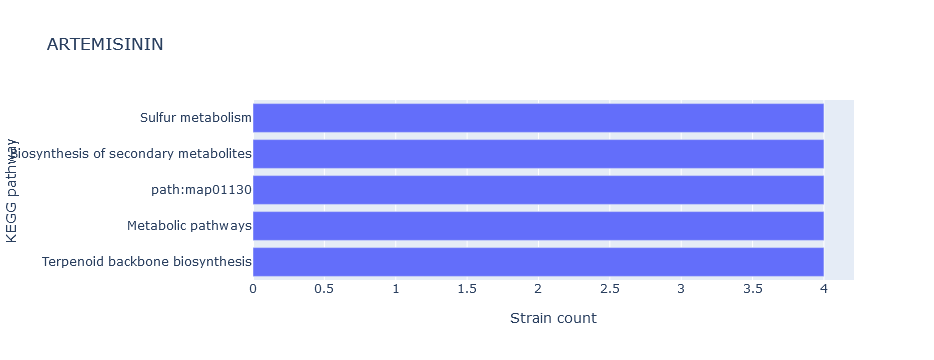

In [200]:
cond_dict = path_across_strains_enrich[cond_idx]

if len(cond_dict)>0:

    if max(cond_dict.values()) >= 3:

        kegg_ids = list(cond_dict.keys())
        strain_count = list(cond_dict.values())

        path_names = []
        for p_id in kegg_ids:
            p_id = 'path:'+ p_id
            if p_id in list(path_annot_ref_table['path_id']):
                path_names.append(path_annot_ref_table.loc[path_annot_ref_table['path_id']==p_id,'path_name'].values[0])

            else:
                path_names.append(p_id)

        enrich_df = pd.DataFrame({'KEGG pathway ID':kegg_ids, 'Strain count':strain_count,\
                                 'KEGG pathway':path_names})

        enrich_df = enrich_df.sort_values(by = "Strain count")

        fig = px.bar(enrich_df, x="Strain count", y="KEGG pathway", orientation='h',\
        width=900, height=enrich_df.shape[0]*25+150, title = cond)
        fig.show()

        plt.close('all')

In [81]:
cond_dict = path_across_strains_enrich[cond_idx]

if len(cond_dict)>0:

    if max(cond_dict.values()) >= 3:

        kegg_ids = list(cond_dict.keys())
        strain_count = list(cond_dict.values())

        path_names = []
        for p_id in kegg_ids:
            p_id = 'path:'+ p_id
            if p_id in list(path_annot_ref_table['path_id']):
                path_names.append(path_annot_ref_table.loc[path_annot_ref_table['path_id']==p_id,'path_name'].values[0])

            else:
                path_names.append(p_id)

        enrich_df = pd.DataFrame({'KEGG pathway ID':kegg_ids, 'Strain count':strain_count,\
                                 'KEGG pathway':path_names})

        enrich_df = enrich_df.sort_values(by = "Strain count")

In [133]:
enrich_df_red = enrich_df.loc[enrich_df['Strain count']>20,:]

In [172]:
pyl_col_dict = {'Lentisphaerae':'#DB57C0', 'Verrucomicrobia':'#579BDB','Actinobacteria':'#57DBAA','Proteobacteria':'#dbd057', 'Bacteroidetes':'#db5f57', 'Firmicute':'#75db57'}

In [173]:
phyla_to_test = list(pyl_col_dict.keys())

In [174]:
for col in phyla_to_test:
    enrich_df_red[col] = [0 for el in range(enrich_df_red.shape[0])]

C:\Users\clanc\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [175]:
# get phylum of affected strains

for path in enrich_df_red['KEGG pathway ID']:
    
    affected_strains = stitch_res_all_paths.loc[[path in str(els) for els in stitch_res_all_paths['PHENYTOIN SODIUM']],:].index
    
    strain_phyl_list = [strain_info.loc[strain, 'phylum'] for strain in affected_strains]
    
    occur_dict = dict(Counter(strain_phyl_list))
    
    vals_to_add = []

    for phyl in phyla_to_test:

        if phyl in list(occur_dict.keys()):
            vals_to_add.append(occur_dict[phyl])
        else:
            vals_to_add.append(0)
        
    enrich_df_red.loc[enrich_df_red['KEGG pathway ID']==path, phyla_to_test] = vals_to_add

C:\Users\clanc\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [176]:
enrich_df_red.index = enrich_df_red['KEGG pathway']

In [188]:
stitch_res_all_paths.shape

(45, 269)

<Figure size 432x252 with 0 Axes>

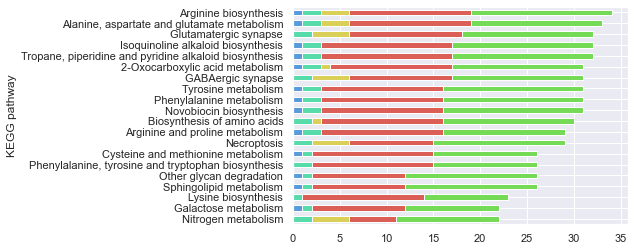

In [180]:
plt.figure(figsize=(6,3.5))

enrich_df_red.loc[:,phyla_to_test].plot(kind='barh', stacked=True, color=pyl_col_dict.values(), legend=False)

plt.savefig('intermed_results/18_stitch/top_PHENYTOIN_paths.svg', bbox_inches='tight')

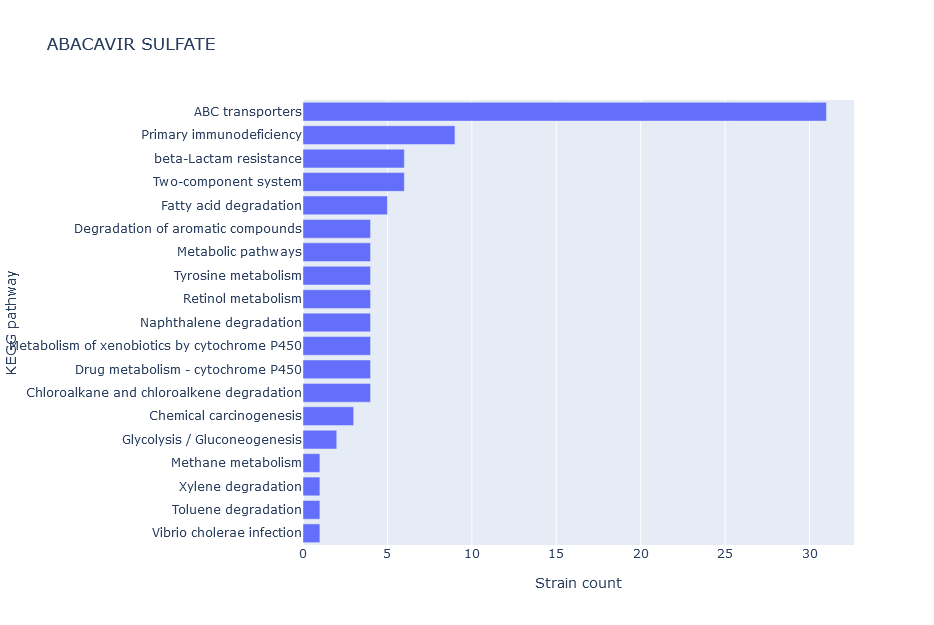

In [24]:
# show the bar plots for conditions with at least 3 strains with common response

for cond_idx,cond in enumerate(condition_list[:5]):
    
    cond_dict = path_across_strains_enrich[cond_idx]
    
    if len(cond_dict)>0:
    
        if max(cond_dict.values()) >= 3:
        
            kegg_ids = list(cond_dict.keys())
            strain_count = list(cond_dict.values())
            
            path_names = []
            for p_id in kegg_ids:
                p_id = 'path:'+ p_id
                if p_id in list(path_annot_ref_table['path_id']):
                    path_names.append(path_annot_ref_table.loc[path_annot_ref_table['path_id']==p_id,'path_name'].values[0])
                
                else:
                    path_names.append(p_id)

            enrich_df = pd.DataFrame({'KEGG pathway ID':kegg_ids, 'Strain count':strain_count,\
                                     'KEGG pathway':path_names})
            
            enrich_df = enrich_df.sort_values(by = "Strain count")

            fig = px.bar(enrich_df, x="Strain count", y="KEGG pathway", orientation='h',\
            width=900, height=enrich_df.shape[0]*25+150, title = cond)
            fig.show()
            
            plt.close('all')

        